In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
from meshcat.transformations import translation_matrix, rotation_matrix
from meshcat.geometry import Box, MeshPhongMaterial, Cylinder
from scipy.optimize import minimize

### Visualization

In [2]:
# specify a path the the urdf files and meshes
urdf_model_path = "diffdrive.urdf"
mesh_dir = ""

""" 
Initalize parameters for the robot
"""

RADIUS = 0.25  # Radius of the robot (from the URDF)
# START = [-4.6, 2, 0]  # Starting position of the robot
START = [2, 4, 0] 
GOAL = [-2, -2, 0]  # Goal position of the robot
SEED = 42 # Seed for random number generation
NUMBER_OF_NODES = 1000 # Number of nodes in the graph
NUMBER_OF_NEIGHBORS = 10 # Number of neighbors to consider for each node

# load the robot using pinocchio
robot = pin.RobotWrapper.BuildFromURDF(urdf_model_path, mesh_dir)

# vizualize the robot using meshcat
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)

def show_robot(x,y,theta):
    quat = pin.Quaternion(pin.utils.rotate('z', theta)).coeffs()
    pos = np.array([x,y,0.1])

    viz.display(np.append(pos,quat))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
# Add a floor
# Add floor material
material_floor = MeshPhongMaterial()
material_floor.color = int(200) * 256**2 + int(200) * 256 + int(200)
# Add a floor
viz.viewer["/Floor"].set_object(
    Box([10, 10, 0.01]),
    material_floor
)
viz.viewer["/Floor"].set_transform(
    translation_matrix([0, 0, -0.005])
)

# Add obstacle material
material_obstacle = MeshPhongMaterial()
material_obstacle.color = int(100) * 256**2 + int(100) * 256 + int(100)

# Randomly generate 10 obstacle positions within a defined range
np.random.seed(SEED)
obstacle_positions = [
    np.array([np.random.uniform(-4.8, 4.8), np.random.uniform(-4.8, 4.8), 0.5])
    for _ in range(10)
] # 10 obstacles, defined as x, y, z positions

# add cylinders for each obstacle
for i, pos in enumerate(obstacle_positions):
    viz.viewer[f"/Obstacle_{i}"].set_object(
        Cylinder(1, 0.2), material_obstacle
    )
    T_world_obs = translation_matrix(pos)
    T_world_obs[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Obstacle_{i}"].set_transform(
        T_world_obs
    )

# Add walls between obstacles, for every two obstacles
for i, pos in enumerate(obstacle_positions[::2]):
    # Connect a wall (box) between the two obstacles
    wall_length = np.linalg.norm(obstacle_positions[2*i][:2] - obstacle_positions[2*i+1][:2])
    wall_width = 0.4
    wall_height = 1.0
    wall_material = MeshPhongMaterial()
    wall_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

    wall_position = (obstacle_positions[2*i][:2] + obstacle_positions[2*i+1][:2]) / 2

    viz.viewer[f"/Wall_Obstacle_{i}"].set_object(
        Box([wall_length, wall_width, wall_height]), wall_material
    )
    # Set the wall rotation to align with the line between the two obstacles
    angle = np.arctan2(
        obstacle_positions[2*i+1][1] - obstacle_positions[2*i][1],
        obstacle_positions[2*i+1][0] - obstacle_positions[2*i][0]
    )
    viz.viewer[f"/Wall_Obstacle_{i}"].set_transform(
        translation_matrix([wall_position[0], wall_position[1], wall_height / 2]) @
        rotation_matrix(angle, [0, 0, 1])
    )

# Add walls around the floor
wall_thickness = 0.1
wall_height = 1.0

# Left wall
viz.viewer["/Wall_Left"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Left"].set_transform(
    translation_matrix([-5 - wall_thickness / 2, 0, wall_height / 2])
)

# Right wall
viz.viewer["/Wall_Right"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Right"].set_transform(
    translation_matrix([5 + wall_thickness / 2, 0, wall_height / 2])
)

# Front wall
viz.viewer["/Wall_Front"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Front"].set_transform(
    translation_matrix([0, 5 + wall_thickness / 2, wall_height / 2])
)

# Back wall
viz.viewer["/Wall_Back"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Back"].set_transform(
    translation_matrix([0, -5 - wall_thickness / 2, wall_height / 2])
)

# can you add a tower in each corner of the walls?
tower_height = 1.5
tower_radius = 0.3
tower_material = MeshPhongMaterial()
tower_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

tower_positions = [
    np.array([-5 - wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    # first element is the x position, second is the y position, third is the z position
    np.array([5 + wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    np.array([-5 - wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2]),
    np.array([5 + wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2])
]

for i, pos in enumerate(tower_positions):
    viz.viewer[f"/Tower_{i}"].set_object(
        Cylinder(tower_height, tower_radius), tower_material
    )
    T_world_tower = translation_matrix(pos)
    T_world_tower[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Tower_{i}"].set_transform(
        T_world_tower
    )

In [4]:
x, y, theta = START
# grid is:
# x [-5, 5]
# y [-5, 5]
# theta [0, 2*pi]
show_robot(x,y,theta)

### Simulation

In [5]:
# Define robot dynamics
def discrete_dynamics(state, control_input, dt, model_mismatch=False):
    """
    Update the robot's state based on its dynamics.

    Parameters:
    - state: Current state [x, y, theta]
    - control_input: Control input [linear_velocity, angular_velocity]
    - dt: Time step

    Returns:
    - Updated state [x, y, theta]
    """
    x, y, theta = state
    linear_velocity, angular_velocity = control_input
    if model_mismatch:
        # Introduce model mismatch by adding noise to the control input
        linear_velocity += np.random.normal(0, 1.0)
        angular_velocity += np.random.normal(0, 1.0)

    # Update state using differential drive kinematics
    x += linear_velocity * np.cos(theta) * dt
    y += linear_velocity * np.sin(theta) * dt
    theta += angular_velocity * dt

    # Normalize theta to keep it within [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))

    return np.array([x, y, theta])


In [6]:
def simulation(controller, mismatch=False):
    # Simulation parameters
    dt = 0.01  # Time step (s)
    simulation_time = 30  # Total simulation time (s)
    sensor_noise_stddev = 0.03  # Standard deviation of sensor noise (m)

    # Initial robot position and orientation
    x, y, theta = START  # Initial position (x, y) and orientation (theta)

    # Simulation loop
    for t in np.arange(0, simulation_time, dt):

        z = np.array([x,y]) + np.random.normal(0, sensor_noise_stddev, 2)  # Simulated sensor measurement with noise

        # calculate control inputs
        u,w = controller(x,y,theta,z)
        # u = linear_velocity
        # w = angular_velocity

        # Update robot position and orientation using differential drive kinematics
        x, y, theta = discrete_dynamics([x, y, theta], [u,w], dt, model_mismatch=mismatch)

        # Normalize theta to keep it within [-pi, pi]
        theta = np.arctan2(np.sin(theta), np.cos(theta))

        # Display the robot in the visualization
        show_robot(x, y, theta)
        # Calculate and visualize distances to towers
        
        if np.linalg.norm([x - GOAL[0], y - GOAL[1]]) <= 0.2:
            print("Goal reached!")
            break

        # Pause to simulate real-time visualization
        time.sleep(dt)

# Motion Planning

### Collision Check Function

In [7]:
def get_obstacles():
    """ 
    Obstacles are defined as a list of tuples, where each tuple contains:
    - start point (x, y)
    - end point (x, y)
    - radius (for cylindrical obstacles)
    The obstacles are defined as follows:
    1. Individual cylindrical obstacles (radius = 0.2)
    2. Walls between obstacle pairs (width = 0.4 -> radius = 0.2)
    3. Boundary walls (thickness = 0.1 -> radius = 0.05)
    4. Corner towers (radius = 0.3)
    """
    obstacles = []

    # 1. Individual cylindrical obstacles (radius = 0.2)
    for pos in obstacle_positions:
        x, y = pos[0], pos[1]
        obstacles.append(((x, y), (x, y), 0.2))  # Zero-length capsule (circle)

    # 2. Walls between obstacle pairs (width = 0.4 -> radius = 0.2)
    for i in range(len(obstacle_positions) // 2):
        start_obs = obstacle_positions[2*i]
        end_obs = obstacle_positions[(2*i)+1]
        start = (start_obs[0], start_obs[1])
        end = (end_obs[0], end_obs[1])
        obstacles.append((start, end, 0.2))

    # 3. Boundary walls (thickness = 0.1 -> radius = 0.05)
    obstacles.extend([
        # Left wall (x=-5.05)
        ((-5.05, -5), (-5.05, 5), 0.05),
        # Right wall (x=5.05)
        ((5.05, -5), (5.05, 5), 0.05),
        # Front wall (y=5.05)
        ((-5, 5.05), (5, 5.05), 0.05),
        # Back wall (y=-5.05)
        ((-5, -5.05), (5, -5.05), 0.05)
    ])

    # 4. Corner towers (radius = 0.3)
    for pos in tower_positions:
        x, y = pos[0], pos[1]
        obstacles.append(((x, y), (x, y), 0.3))

    return obstacles

obstacles = get_obstacles()  # Get the list of obstacles

def distance_point_to_segment(p, a, b):
    """ 
    Calculate the distance from point p to the line segment defined by points a and b.
    Parameters:
    - p: Point (x, y) as a numpy array
    - a: Start point of the segment (x, y) as a numpy array
    - b: End point of the segment (x, y) as a numpy array
    Returns:
    - Distance from point p to the segment ab.
    """
    ap = p - a # Vector from a to p
    ab = b - a # Vector from a to b
    t = np.dot(ap, ab) / (np.dot(ab, ab) + 1e-8) # Project p onto line ab
    # 1e-8 is added to avoid division by zero
    t = np.clip(t, 0.0, 1.0) # Clamp projection to the segment [a, b]
    closest = a + t * ab # Closest point on the segment to p
    return np.linalg.norm(p - closest) # Euclidean distance

def is_collision(path, obstacles, robot_radius=RADIUS):
    """ 
    Check if the path collides with any obstacles.
    Parameters:
    - path: List of points representing the path [(x1, y1), (x2, y2), ...]
    - obstacles: List of obstacles, each defined by a tuple (start, end, radius)
                 where start and end are points defining the obstacle segment
                 and radius is the radius of the obstacle.
    - robot_radius: Radius of the robot (default is 1.0)
    Returns:
    - True if the path collides with any obstacle, False otherwise.
    """
    for (x, y) in path:
        for (start, end, radius) in obstacles:
            distance = distance_point_to_segment(np.array([x, y]), np.array(start), np.array(end))
            if distance < (robot_radius + radius):
                return True
    return False

### Optimization-Based Local Planner (Ignoring Obstacles)

In [8]:
from scipy.optimize import minimize

def compute_final_state(start, v, omega, t):
    """
    Function to compute the final state of the robot given the initial state,
    linear velocity, angular velocity, and time duration.
    
    Parameters:
    - start: Initial state [x0, y0, theta0]
    - v: Linear velocity
    - omega: Angular velocity
    - t: Time duration
    Returns:
    - Final state [x, y, theta]
    """
    
    x0, y0, theta0 = start
    if np.isclose(omega, 0.0):
        x = x0 + v * t * np.cos(theta0)
        y = y0 + v * t * np.sin(theta0)
        theta = theta0
    else:    
        theta = theta0 + omega * t
        theta = np.arctan2(np.sin(theta), np.cos(theta))  # Normalize
        x = x0 + (v / omega) * (np.sin(theta) - np.sin(theta0))
        y = y0 + (v / omega) * (np.cos(theta0) - np.cos(theta))
    return np.array([x, y, theta])

def local_planner(start, goal, robot_radius=RADIUS):
    """
    Local planner to compute the optimal linear and angular velocities
    to reach a goal position while ignoring obstacles.
    Uses optimization to find the best velocities and time duration.
    
    Parameters:
    - start: Initial state [x0, y0, theta0]
    - goal: Goal state [x_goal, y_goal, theta_goal]
    - robot_radius: Radius of the robot (default is 1.0)
    Returns:
    - v_opt: Optimal linear velocity
    - omega_opt: Optimal angular velocity
    - t_opt: Optimal time duration
    - path: List of positions (x, y) along the path to the goal
    """
    def objective(variables):
        v, omega, t = variables
        final_state = compute_final_state(start, v, omega, t)
        error = final_state[:2] - goal[:2]
        return np.sum(error**2) + 0.1 * t  # penalize time and position error
    
    dx = goal[0] - start[0]
    dy = goal[1] - start[1]
    distance = np.hypot(dx, dy)
    initial_theta = start[2]
    # initial_v = distance / 1.0 if distance > 0 else 0.0
    direction = np.sign(np.cos(initial_theta - start[2]))  # is goal roughly forward or backward
    initial_v = direction * distance / 1.0
    initial_omega = (initial_theta - start[2]) / 1.0
    initial_guess = [initial_v, initial_omega, 1.0]
    
    bounds = [(-3.0, 3.0), (-2.0, 2.0), (0.1, 5.0)] 
    
    result = minimize(objective, initial_guess, bounds=bounds, method='SLSQP')
    
    if not result.success:        
        print(f"Local planner failed! Start: {start}, Goal: {goal}")
        return 0.0, 0.0, 0.0, []
    
    v_opt, omega_opt, t_opt = result.x
    dt = 0.1
    time_steps = int(t_opt / dt)
    path = []
    current_state = np.array(start)
    for _ in range(time_steps):
        current_state = discrete_dynamics(current_state, [v_opt, omega_opt], dt, model_mismatch=False)
        path.append(current_state[:2])
    
    if path and not is_collision(path, obstacles, robot_radius):
        return v_opt, omega_opt, t_opt, path
    return v_opt, omega_opt, t_opt, path

### PRM

In [9]:
from scipy.spatial import KDTree

class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," +\
               str(self.cost) + "," + str(self.parent_index)
               
def sample_points(sx, sy, gx, gy, robot_radius, obstacles, rng=None):
    """
    This function samples points in the environment while avoiding obstacles.
    It generates random points within a defined range and checks for collisions
    with obstacles. The function returns a list of sampled points including the
    start and goal positions.
    Parameters:
    - sx: Start x-coordinate
    - sy: Start y-coordinate
    - gx: Goal x-coordinate
    - gy: Goal y-coordinate
    - robot_radius: Radius of the robot
    - obstacles: List of obstacles defined as tuples (start, end, radius)
    - rng: Random number generator (optional)
    Returns:
    - sample_x: List of 500 sampled x-coordinates + [sx, gx]
    - sample_y: List of 500 sampled y-coordinates + [sy, gy]
    """
    min_x, max_x = -5, 5
    min_y, max_y = -5, 5
    sample_x, sample_y = [], []
    rng = np.random.default_rng() if rng is None else rng
    while len(sample_x) < NUMBER_OF_NODES: # number of sample points
        tx = rng.uniform(min_x, max_x)
        ty = rng.uniform(min_y, max_y)
        if not is_collision([(tx, ty)], obstacles, robot_radius):
            sample_x.append(tx)
            sample_y.append(ty)
    sample_x += [sx, gx]
    sample_y += [sy, gy]
    return sample_x, sample_y

def generate_road_map(sample_x, sample_y, robot_radius, obstacles):
    """
    Generate a road map (graph) from sampled points. (PRM)
    This function creates a road map by connecting sampled points with edges
    based on local planning. It uses a KDTree for efficient nearest neighbor search
    and checks for collisions with obstacles. Each sampled point is connected to
    its nearest neighbors, forming a graph structure.
    Parameters:
    - sample_x: List of sampled x-coordinates
    - sample_y: List of sampled y-coordinates
    - robot_radius: Radius of the robot
    - obstacles: List of obstacles defined as tuples (start, end, radius)
    Returns:
    - road_map: List of edges for each sampled point, where each edge is a list of indices
                of connected points. Each index corresponds to a point in sample_x and sample_y.
    """
    road_map = []
    sample_kd_tree = KDTree(np.vstack((sample_x, sample_y)).T)
    # intialize fast nearest-neighbor lookup from all sample points
    for i in range(len(sample_x)):
        ix, iy = sample_x[i], sample_y[i]
        dists, indexes = sample_kd_tree.query([ix, iy], k=len(sample_x))
        # indexes = indices of all points sorted by distance
        edge_id = []
        for j in indexes[1:]: # skip the first point (itself)
            nx, ny = sample_x[j], sample_y[j]
            start_theta = np.arctan2(ny - iy, nx - ix) # angle to the point
            goal_theta = start_theta # orientation of the robot
            start = [ix, iy, start_theta]
            goal = [nx, ny, goal_theta]
            _, _, _, path = local_planner(start, goal, robot_radius)
            if path and not is_collision(path, obstacles, robot_radius):
                edge_id.append(j)
            if len(edge_id) >= NUMBER_OF_NEIGHBORS:
                break
        road_map.append(edge_id)
    return road_map

def dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y):
    """ 
    Dijkstra's algorithm for path planning.
    This function implements Dijkstra's algorithm to find the shortest path
    from the start node to the goal node in a road map. It uses a priority queue
    to explore nodes based on their cost and maintains a closed set of visited nodes.
    Parameters:
    - sx: Start x-coordinate
    - sy: Start y-coordinate
    - gx: Goal x-coordinate
    - gy: Goal y-coordinate
    - road_map: List of edges for each sampled point, where each edge is a list of indices
    - sample_x: List of sampled x-coordinates
    - sample_y: List of sampled y-coordinates
    Returns:
    - rx: List of x-coordinates of the path from start to goal
    - ry: List of y-coordinates of the path from start to goal
    """
    start_node = Node(sx, sy, 0.0, -1) # x, y, cost, parent_index
    goal_node = Node(gx, gy, 0.0, -1)
    # open = unvisited nodes, closed = visited nodes
    open_set, closed_set = {len(sample_x)-2: start_node}, {} # start node and empty closed set
    
    # Continue until all reachable nodes are visited or goal is found
    while open_set:
        c_id = min(open_set, key=lambda k: open_set[k].cost)
        current = open_set[c_id]
        if c_id == len(sample_x)-1:
            rx, ry = [current.x], [current.y]
            while current.parent_index != -1:
                current = closed_set[current.parent_index]
                rx.append(current.x)
                ry.append(current.y)
            return rx[::-1], ry[::-1]
        del open_set[c_id] # remove current node from open set
        closed_set[c_id] = current # add current node to closed set
        for n_id in road_map[c_id]: # iterate over neighbors
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = np.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id], current.cost + d, c_id)
            if n_id in closed_set:
                continue
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id] = node
            else:
                open_set[n_id] = node
    return [], []

# Extended Kalman filter

In [10]:
class ExtendedKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, measurement_noise):
        self.state = np.array(initial_state)  # [x, y, theta]
        self.covariance = np.array(initial_covariance)  # 3x3 matrix
        self.process_noise = np.array(process_noise)  # Q (3x3)
        self.measurement_noise = np.array(measurement_noise)  # R (2x2)
        self.H = np.array([[1, 0, 0], [0, 1, 0]])  # Measurement matrix

    def predict(self, control_input, dt):
        """
        Predict step using control inputs (v, omega).
        """
        v, omega = control_input
        x, y, theta = self.state

        # Jacobian of motion model (A)
        F = np.eye(3)
        F[0, 2] = -v * np.sin(theta) * dt
        F[1, 2] = v * np.cos(theta) * dt

        # Predict state using discrete dynamics
        self.state = discrete_dynamics(self.state, [v, omega], dt, model_mismatch=False)

        # Update covariance: P = FPF^T + Q
        self.covariance = F @ self.covariance @ F.T + self.process_noise

    def update(self, measurement):
        """
        Update step using GPS measurement (x, y).
        """
        z = np.array(measurement)
        H = self.H

        # Kalman gain: K = P H^T (H P H^T + R)^-1
        S = H @ self.covariance @ H.T + self.measurement_noise
        K = self.covariance @ H.T @ np.linalg.inv(S)

        # Update state and covariance
        y = z - H @ self.state
        self.state += K @ y
        self.covariance = (np.eye(3) - K @ H) @ self.covariance

    def get_estimate(self):
        return self.state

# Full motion planner

/home/thibault/miniconda3/envs/py13roboticscourse/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/thibault/miniconda3/envs/py13roboticscourse/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Generating reference trajectory...
Starting at: 2.00, 4.00, theta=0.00


/home/thibault/miniconda3/envs/py13roboticscourse/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


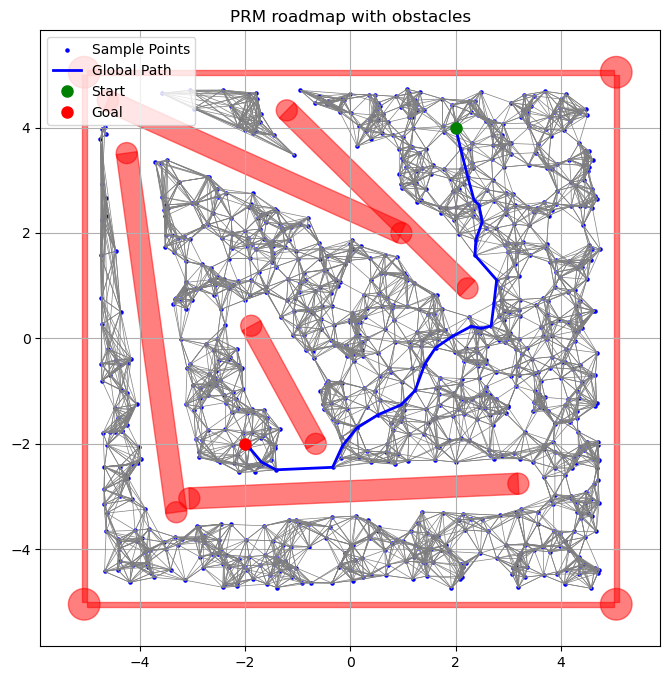

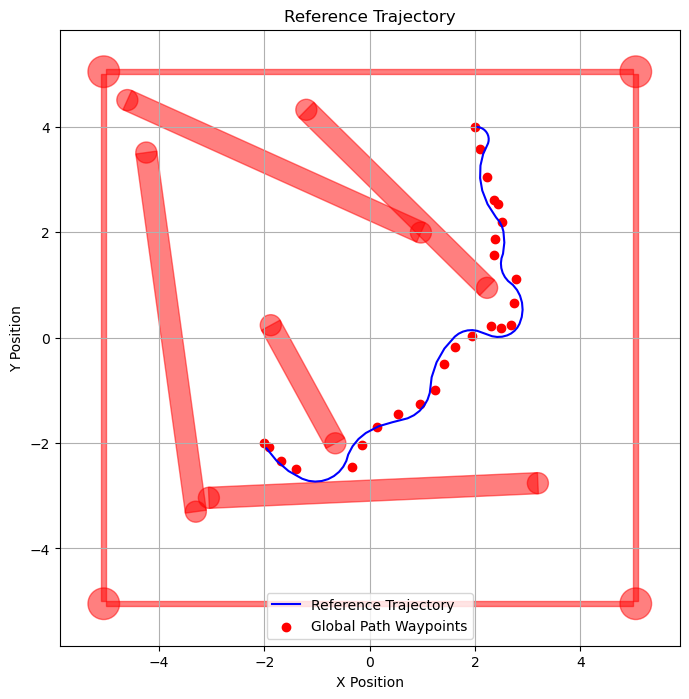

[{'x': np.float64(2.046878027199556), 'y': np.float64(4.0), 'theta': np.float64(-0.2), 't': 0.0, 'v': np.float64(0.46878027199556077), 'omega': np.float64(-2.0)}, {'x': np.float64(2.0928216148929737), 'y': np.float64(3.9906867737072713), 'theta': np.float64(-0.4), 't': 0.1, 'v': np.float64(0.46878027199556077), 'omega': np.float64(-2.0)}, {'x': np.float64(2.1359991372222913), 'y': np.float64(3.9724316100645205), 'theta': np.float64(-0.6000000000000002), 't': 0.2, 'v': np.float64(0.46878027199556077), 'omega': np.float64(-2.0)}, {'x': np.float64(2.1746892426267896), 'y': np.float64(3.9459622848386835), 'theta': np.float64(-0.8000000000000002), 't': 0.30000000000000004, 'v': np.float64(0.46878027199556077), 'omega': np.float64(-2.0)}, {'x': np.float64(2.207349478697679), 'y': np.float64(3.9123340464977283), 'theta': np.float64(-1.0000000000000002), 't': 0.4, 'v': np.float64(0.46878027199556077), 'omega': np.float64(-2.0)}, {'x': np.float64(2.2326777848881485), 'y': np.float64(3.872887546

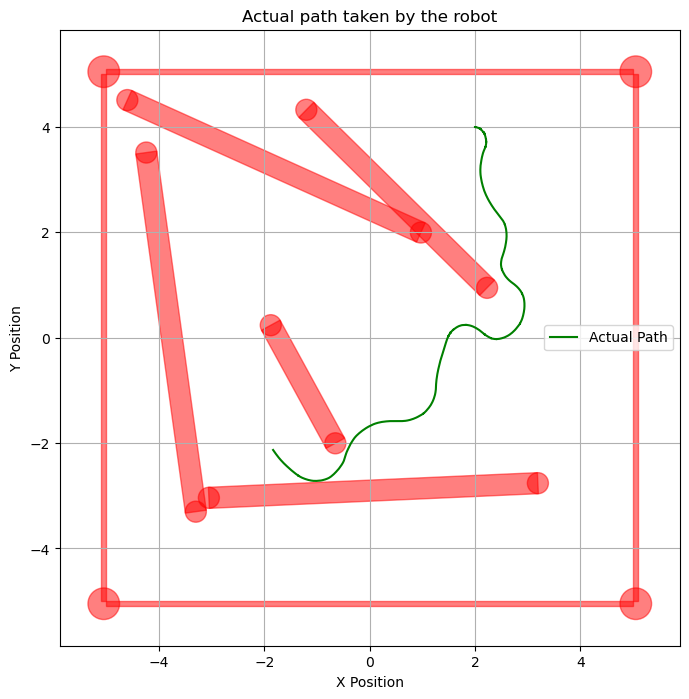

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import matplotlib.transforms as transforms

class MotionPlanner:
    def __init__(self, start, goal, obstacles):
        self.obstacles = obstacles
        self.robot_radius = RADIUS
        self.sample_x, self.sample_y = sample_points(start[0], start[1], goal[0], goal[1], self.robot_radius, obstacles)
        self.road_map = generate_road_map(self.sample_x, self.sample_y, self.robot_radius, obstacles)
        self.global_path_x, self.global_path_y = dijkstra_planning(start[0], start[1], goal[0], goal[1], self.road_map, self.sample_x, self.sample_y)
        self.current_idx = 0
        
        self.ref_traj = None
        self.ref_traj = self.reference_trajectory()
        self.ref_idx = 0
        self.start_time = None  # Initialize start time for reference trajectory        
        
        self.actual_path_x = [(start[0], start[1])]

    def basic_control(self, x, y, theta):
        """
        Returns the control inputs (linear and angular velocities) for the robot
        to follow the global path towards the next waypoint.
        If the robot is close enough to the next waypoint, it moves to the next one.
        Parameters:
        - x: Current x position of the robot
        - y: Current y position of the robot
        - theta: Current orientation of the robot (in radians)
        Returns:
        - v: Linear velocity to apply
        - omega: Angular velocity to apply
        """
        if self.current_idx >= len(self.global_path_x) - 1:
            print("No more waypoints to follow. Stopping.")
            return 0.0, 0.0
        self.actual_path_x.append((x, y))
        if np.linalg.norm([x - self.global_path_x[-1], y - self.global_path_y[-1]]) < 0.15:
            # print("Reached the goal! Stopping.")
            return 0.0, 0.0
        
        target_x = self.global_path_x[self.current_idx + 1]
        target_y = self.global_path_y[self.current_idx + 1]
        
        # Calculate angle to target
        target_angle = np.arctan2(target_y - y, target_x - x)
        angle_error = target_angle - theta
        
        # Pure rotation phase if misaligned (only for first waypoint)
        if (self.current_idx == 0 and np.abs(angle_error) > 0.2):  # 11.5 degrees
            omega = np.clip(2.0 * angle_error, -4.0, 4.0)
            return 0.0, omega  # Rotate in place
    

        start = [x, y, theta]
        goal_theta = np.arctan2(target_y - y, target_x - x)
        goal = [target_x, target_y, goal_theta] 
        
        # try to find a valid path using local planner (there exist one but sometimes it generates a collision)
        v, omega, _, path = local_planner(start, goal, self.robot_radius)
        i = 0
        while (path and is_collision(path, self.obstacles, self.robot_radius)) and (i < 10):
            i += 1
            theta_inverse = np.arctan2(np.sin(theta+np.pi), np.cos(theta+np.pi))
            start2 = [x, y, theta_inverse]
            v, omega, _, path = local_planner(start, goal, robot_radius=RADIUS)
        
        if v is None or omega is None:
            print("Invalid control (None detected)! Using zeros.")            
            return 0.0, 0.0  # Stop the robot
        if np.hypot(target_x - x, target_y - y) < 0.3:  # If close enough to the next waypoint
            # if not (self.current_idx + 2 < len(self.global_path_x)):
            #     # print("Reached the goal waypoint! Stopping.")
            # else:
                # print(f"Reached waypoint {self.current_idx}. Advancing to next.")
                # print(f"Current location: ({x:.2f}, {y:.2f}). Next goal location: ({self.global_path_x[self.current_idx + 2]:.2f}, {self.global_path_y[self.current_idx + 2]:.2f})")
                
            self.current_idx += 1
        return v, omega
    
    def reference_trajectory(self):
        """ 
        Generates a full reference trajectory using local planner between consecutive waypoints
        Returns list of (x, y, theta, t) states with timestamps
        """
        if self.ref_traj is not None:
            return self.ref_traj
        
        full_trajectory = []
        current_time = 0.0
        current_state = np.array([self.global_path_x[0], self.global_path_y[0], START[2]])  # Initial orientation
        
        # Create trajectory for each segment of the global path
        for i in range(len(self.global_path_x)-1):
            start = current_state.copy()
            goal_theta = np.arctan2(self.global_path_y[i+1] - start[1], 
                                   self.global_path_x[i+1] - start[0])
            goal = [self.global_path_x[i+1], self.global_path_y[i+1], goal_theta]
            
            # Get local path from planner
            v, omega, t, path = local_planner(start, goal, self.robot_radius) 
            j = 0
            while (path and is_collision(path, self.obstacles, self.robot_radius)) and (j < 10):
                j += 1
                theta_inverse = np.arctan2(np.sin(theta+(j* np.pi/2)), np.cos(theta+ (j*np.pi/2)))
                v, omega, t, path = local_planner(start, goal, robot_radius=RADIUS)
            
            if len(path) == 0:
                continue
                
            # Simulate trajectory with timestamps
            dt = 0.1
            time_steps = int(t / dt)
            current_state_sim = start.copy()
            for _ in range(time_steps):
                current_state_sim = discrete_dynamics(current_state_sim, [v, omega], dt, model_mismatch=False)
                full_trajectory.append({
                    'x': current_state_sim[0],
                    'y': current_state_sim[1],
                    'theta': current_state_sim[2],
                    't': current_time,
                    'v': v,
                    'omega': omega
                })
                current_time += dt
            
            current_state = current_state_sim.copy()
        
        self.ref_traj = full_trajectory
        return full_trajectory
    
    def plot_ref_traj(self):
        """
        Plots the reference trajectory generated by the reference_trajectory method.
        """
        if self.ref_traj is None:
            print("Reference trajectory not generated yet.")
            return
        
        plt.figure(figsize=(8, 8))
        plt.axis("equal")
        
        # Extract x, y, theta from the reference trajectory
        x = [state['x'] for state in self.ref_traj]
        y = [state['y'] for state in self.ref_traj]
        
        plt.plot(x, y, label="Reference Trajectory", color='blue')
        plt.scatter(self.global_path_x, self.global_path_y, color='red', label="Global Path Waypoints")
        
        # Plot obstacles
        for (start, end, radius) in self.obstacles:
            if start == end:  # Circle (cylinder or tower)
                circle = Circle(start, radius, color="red", alpha=0.5)
                plt.gca().add_patch(circle)
            else:
                dx = end[0] - start[0]
                dy = end[1] - start[1]
                length = np.hypot(dx, dy)
                angle = np.arctan2(dy, dx)
                center_x = (start[0] + end[0]) / 2
                center_y = (start[1] + end[1]) / 2

                # Create unrotated rectangle
                box = Rectangle(
                    (-length / 2, -radius),  # lower-left corner (local coords)
                    width=length,
                    height=radius * 2,
                    color="red",
                    alpha=0.5
                )

                # Rotate and move the rectangle to its position
                t = transforms.Affine2D().rotate(angle).translate(center_x, center_y) + plt.gca().transData
                box.set_transform(t)
                plt.gca().add_patch(box)
        
        plt.title("Reference Trajectory")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def reference_trajectory_control(self, x, y, theta):
        """
        Takes the current state of the robot and returns the control inputs
        (linear and angular velocities) to follow the reference trajectory.
        Parameters:
        - x: Current x position of the robot
        - y: Current y position of the robot
        - theta: Current orientation of the robot (in radians)
        Returns:
        - v: Linear velocity to apply
        - omega: Angular velocity to apply
        """
        # Store actual path
        self.actual_path_x.append((x, y))
        
        # Early exit if at goal
        if np.linalg.norm([x - GOAL[0], y - GOAL[1]]) < 0.15:
            return 0.0, 0.0

        # Controller gains (adjusted for better stability)
        k1 = 1.0
        k2 = 1.5
        k3 = 2.5
        EPS = 1e-8  # Anti-division-by-zero

        # Find nearest reference point using Euclidean distance
        current_pos = np.array([x, y])
        ref_points = np.array([[p['x'], p['y']] for p in self.ref_traj])
        distances = np.linalg.norm(ref_points - current_pos, axis=1)
        closest_idx = np.argmin(distances)
        
        ref_state = self.ref_traj[closest_idx]

        # Get reference values
        x_d = ref_state['x']
        y_d = ref_state['y']
        phi_d = ref_state['theta']
        v_d = ref_state['v']
        omega_d = ref_state['omega']

        # Error transformation matrix (fixed orientation)
        R = np.array([
            [np.cos(phi_d), np.sin(phi_d), 0],
            [-np.sin(phi_d), np.cos(phi_d), 0],
            [0, 0, 1]
        ])
        
        # Compute errors
        pose_error = np.array([x - x_d, y - y_d, theta - phi_d])
        x_e, y_e, theta_e = R @ pose_error
        
        # theta_e = np.clip(theta_e, -np.deg2rad(90), np.deg2rad(90))  # Prevent division issues

        # Modified control law with feedforward and protection
        try:
            v = (v_d - k1 * abs(v_d) * (x_e + y_e * np.tan(theta_e))) / (np.cos(theta_e) + EPS)
            omega = omega_d - ((k2 * v_d * y_e + k3 * abs(v_d) * np.tan(theta_e)) * (np.cos(theta_e)**2))
        except ZeroDivisionError:
            v, omega = v_d, omega_d
        
        
        # print(f"v_d: {v_d:.2f}, omega_d: {omega_d:.2f}")
        # print(f"x_e: {x_e:.2f}, y_e: {y_e:.2f}, theta_e: {np.degrees(theta_e):.2f}° , v: {v:.2f}, omega: {omega:.2f}")
        # print(f"Ref Traj: t={ref_state['t']:.1f}, v_d={ref_state['v']:.2f}, omega_d={ref_state['omega']:.2f}")
        
        # Higher limits for velocities
        # (The reference trajectory could be planned using not-quite-extremal controls, capped at v=3 and omega=2)
        MAX_V = 5
        MAX_OMEGA = 4
        v = np.clip(v, -MAX_V, MAX_V)
        omega = np.clip(omega, -MAX_OMEGA, MAX_OMEGA)

        # # Add low-pass filter to control outputs
        # if self.last_controls is None:
        #     self.last_controls = np.array([v, omega])
        # else:
        #     alpha = 0.2  # Filter coefficient
        #     self.last_controls = alpha * np.array([v, omega]) + (1-alpha) * self.last_controls
        #     v, omega = self.last_controls

        return float(v), float(omega)
    
    def plot_road_map(self):
        plt.figure(figsize=(8, 8))
        plt.axis("equal")

        # Plot roadmap nodes
        plt.scatter(self.sample_x, self.sample_y, s=5, c="blue", label="Sample Points")

        # Plot roadmap edges
        for i, neighbors in enumerate(self.road_map):
            ix, iy = self.sample_x[i], self.sample_y[i]
            for j in neighbors:
                jx, jy = self.sample_x[j], self.sample_y[j]
                plt.plot([ix, jx], [iy, jy], "gray", linewidth=0.5)

        # Plot obstacles
        for (start, end, radius) in self.obstacles:
            if start == end:  # Circle (cylinder or tower)
                circle = Circle(start, radius, color="red", alpha=0.5)
                plt.gca().add_patch(circle)
            else:
                dx = end[0] - start[0]
                dy = end[1] - start[1]
                length = np.hypot(dx, dy)
                angle = np.arctan2(dy, dx)
                center_x = (start[0] + end[0]) / 2
                center_y = (start[1] + end[1]) / 2

                # Create unrotated rectangle
                box = Rectangle(
                    (-length / 2, -radius),  # lower-left corner (local coords)
                    width=length,
                    height=radius * 2,
                    color="red",
                    alpha=0.5
                )

                # Rotate and move the rectangle to its position
                t = transforms.Affine2D().rotate(angle).translate(center_x, center_y) + plt.gca().transData
                box.set_transform(t)
                plt.gca().add_patch(box)
            
        # Plot global path
        plt.plot(self.global_path_x, self.global_path_y, "b-", linewidth=2, label="Global Path")

        # Plot start and goal
        plt.plot(self.sample_x[-2], self.sample_y[-2], "go", label="Start", markersize=8)
        plt.plot(self.sample_x[-1], self.sample_y[-1], "ro", label="Goal", markersize=8)

        plt.legend()
        plt.title("PRM roadmap with obstacles")
        plt.grid(True)
        plt.show()
        
    def plot_actual_path(self):
        """
        Plots the actual path taken by the robot during the simulation.
        """
        if not self.actual_path_x:
            print("No actual path recorded.")
            return
        
        actual_x, actual_y = zip(*self.actual_path_x)
        
        plt.figure(figsize=(8, 8))
        plt.axis("equal")
        
        # Plot actual path
        plt.plot(actual_x, actual_y, label="Actual Path", color='green')
        
        # Plot obstacles
        for (start, end, radius) in self.obstacles:
            if start == end:  # Circle (cylinder or tower)
                circle = Circle(start, radius, color="red", alpha=0.5)
                plt.gca().add_patch(circle)
            else:
                dx = end[0] - start[0]
                dy = end[1] - start[1]
                length = np.hypot(dx, dy)
                angle = np.arctan2(dy, dx)
                center_x = (start[0] + end[0]) / 2
                center_y = (start[1] + end[1]) / 2

                # Create unrotated rectangle
                box = Rectangle(
                    (-length / 2, -radius), 
                    width=length,
                    height=radius * 2,
                    color="red",
                    alpha=0.5
                )

                # Rotate and move the rectangle to its position
                t = transforms.Affine2D().rotate(angle).translate(center_x, center_y) + plt.gca().transData
                box.set_transform(t)
                plt.gca().add_patch(box)
        
        plt.legend()
        plt.title("Actual path taken by the robot")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.grid(True)
        plt.show()

# Initialize planner with start and goal
start = START
goal = GOAL
obstacles = get_obstacles()
planner = MotionPlanner(start, goal, obstacles)
planner.plot_road_map()
planner.plot_ref_traj()

def controller(x, y, theta, z):
    return planner.reference_trajectory_control(x, y, theta)
    # return planner.basic_control(x, y, theta)


simulation(controller, mismatch=True)

planner.plot_actual_path()

# Discussion

### Part 1: motion planner
In part 1, the assignment consited of designing a motion planner to generate a reference path or trajectory to move the robot from configuration A to a configuration B. Both configurations could be of own choice. The motion planner had to consists three essential parts: an optimization-based local motion planner, a collision checker and a global motion planning using the probabalistic roadmap (PRM) algorithm.\
\
The program above works as follows:\
The execution of the program starts by initializing a few parameters like the robot radius (to avoid collision, calculated from the URDF file), starting point, goal coordinates, seed number (for random obstacle generation), number of random nodes (for PRM algoritm) and number of neighbors to connect to (for PRM algoritm). The initial position of the robot, the obstacles and the system boundaries are vizualized. Then, the defintions of the the implemented functions and classes follow, after which the execution of the motion planner can start. The obstacles (walls and random generated obstacles) are saved to be accessble by the collision checker.\
\
The MotionPlanner is initialized, this consists of:
* Generating a roadmap using the PRM algorithm:
  * Generating 1000 sample points. These sample points are only kept if they are accesible by the robot, i.e. the euclidian distance from the sample coordinates to the nearest obstacle is smaller than the radius of the robot. This way the robot can access every sample point in every possible pose.
  * Connecting the nodes with edges if the local planner can find a path between the two nodes without collision with any of the obstacles. 
  * Using the Dijkstra algorithm to find the shortes path (in euclidian distance) form START to GOAL. This generates the global path. This path consists of waypoints, i.e. nodes that are connected by an edge.
* When the global path is created, the local planner can use these waypoints to generate a reference trajectory. This is the path the robot should follow if there was no model mismatch. 
* Now, the controller comes into play. The robot starts at its initial position and the local planner finds a path to the next waypoint. The local planner returns the optimal velocity $v$ and rotational velocity $\omega$ to execute the found path.
* The output from the controller is passed into the simulator functions, which "executes" the movement for one 0.1 $s$. Then, the new position and next waypoint are given back to the motion planner, which checks if the robor is near the current goal waypoint. If the robot is, the next waypoint becomes the goal.
* These steps loop until the robot is at the GOAL waypoint, after which the simulation stops.\

When implementing en testing this pipeline, some issues were found and adressed.
For the motion planner, the following design choices were made:
1) The goal $\theta$ was not penalized because the distance between two waypoints was too short. The optimizer had to find extreme values to find a suitable path. If for example, two way points are very close but the goal angle was orthogonal to the initial angle, the robot had to take a big detour to end in the goal angle.

2) To find if their was a path between two nodes (during the roadmap generation), the initial orientation ($\theta$) was chosen to be the direction of the line that connects the two nodes. This way, we could be certain there was a possible path between the two nodes. Because the robot has a two parallel wheel differential drive, the robot can turn in place. So it can always take on the right pose before advancing. This means, even when the robot was faced towards a wall with an obstacle directly behind it, it could still navigate out of it by turning 90° first. With this approach, all possible positions and paths could be found in the roadmap generation.

3) The issue above also had to be addressed in the motion planning when using the local planner during simulation. A partial solution was to check the orientation at the start. If the angle between the starting orientation and the line form start to next waypoint was more than 11.5°, the robot would first turn in place until the angle was below 11.5°. After advancing, the local planner calculates the optimal path every 0.1 $s$. This meant reference trajectories like the ones below in the center graph, are smoothened out. This happens because the local planner only calculates the path between the the current position and the next waypoint. So when the robot turn in place and makes a small angle with the direction to the next waypoint, the calculated local path is just a straight line. 

4) As the middle graph in the picture below also shows, because the roadmap generator uses optimal starting angles to find collision-free paths and when the actual orientation of the robot is orthogonal to this optimal angle, this can cause issues in the actual reference path generation. This issue is again solved with the use of the initial rotation in place mention above.

5) The bounds for the optimizer in the local planner were limited because unlimited bounds (which also can cause extreme velocities and angular velocities) caused "glitching" of the robot. In some situations, it found two equal solutions (two half circles) because the robot can go forwards and backwards. This issue was further addressed by checking the angle of the current pose of the robot. If the front was more faced towards the next goal, the initial velocity guess was positive. If the back was faced towards the goal, a negative initial velocity was guessed. 

6) As the first graph in the picture below shows, sometimes the shortes path was not found. In the graph below, the passage around coordinate (-0.75, -2.5) was large enough for the robot to be able to pass. However, because of the random sampling, if the two nodes were not close enough or not low enough, the path was not found. This can possibly be improved by using more samples.

<div style="width: 100vw; display: flex;">
  <img src="PRM_example.png" alt="drawing" style="width: 30%;" />
  <img src="bad_trajectory.png" alt="drawing" style="width: 30%;" />
  <img src="actual_path.png" alt="drawing" style="width: 30%;" />
</div>

7) Because the robot can rotate in place, the reference_trajectory function was later added. Instead of just finding the path from the initial pose, if no collision-free path was found, try finding a path with the robot rotated 90°.

8) The local planner uses SLSQP (sequential least squares programming). This is a popular optimization method for constrained non-linear problems. It's a great choice in this situation because this optimizer handles non-linear dynamics and the low number of constrains well. $1$

9) The motion planner switching the next goal/waypoint whenever the robot gets into a radius of 0.2 (euclidian distance) of the current goal/waypoints. This way, the trajectory of the robot is smoothened and the nearby waypoints can be handled as one.

### Part 2: Reference trajectory tracking
To create a trajectory tracking, model mismatching was activated. The trajectory was created using the same principles as mentioned before. The controller that tracked the trajectory and the errors from diverging from it were just taken from the book (equation 13.30 and 13.31). This gave the following results in the picture below.

<div style="width: 100vw; display: flex;">
  <img src="reference_trajectory_1.png" alt="drawing" style="width: 40%;" />
  <img src="reference_trajectory_2.png" alt="drawing" style="width: 40%;" />
</div>

By tuning the parameters $k1$, $k2$ and $k3$ an optimal tracker was found. $k3$ was tuned the highest because this parameter caused better heading correction (critical for path alignment). The other two parameters were initialy both 1.5 but the robot overshot sometimes so $k1$ was reduced to 1.0.

### Part 3: Estimator

### Part 4: Car-like robot

# References

1) https://mdolab-pyoptsparse.readthedocs-hosted.com/en/latest/optimizers/SLSQP.html
2) https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/ProbabilisticRoadMap/probabilistic_road_map.py
3) MODERN ROBOTICS: MECHANICS, PLANNING, AND CONTROL, (December 30, 2019),  Kevin M. Lynch and Frank C. Park. ISBN 9781107156302